In [1]:
!pip install torch
!pip install classy_vision
!pip install psutil
!pip install segmentation-models-pytorch==0.1.3

     |████████████████████████████████| 358kB 5.8MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 645kB 34.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210330-cp37-none-any.whl size=58838 sha256=7a02f1920619b39137bf16aa3864637ae873a7c167f89f56440d59f05dbcf872
  Stored in directory: /root/.cache/pip/wheels/7b/66/11/7c6a1376038283b46d0973c72503c1c73dec3260a50e12e964
Successfully built fvcore
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 245kB 8.8MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=4690d7865f4f021807dfe0fc525e4148dc7b8219b1fda3d5e7bbb7b21f351594
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f7

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from shutil import copyfile

In [4]:
#copyfile('drive/MyDrive/Colab Notebooks/SIGNATEHiroshimaLemon/data/archive.hdf5','archive.hdf5')
copyfile('drive/MyDrive/Colab Notebooks/SIGNATEHiroshimaLemon/data/archive_test_2.hdf5','archive.hdf5')

'archive.hdf5'

In [5]:
import os
import re
import h5py
import numpy as np
import torch.utils.data
from torch.utils.data import random_split
from classy_vision.dataset import ClassyDataset
from classy_vision.tasks import ClassificationTask
import torchvision.transforms as transforms
from classy_vision.dataset.transforms import build_transforms, ApplyTransformToKey
from classy_vision.dataset.transforms import LightingTransform
from PIL import Image
from math import ceil
import logging
import os
logger = logging.getLogger()
logger.setLevel(os.environ.get("LOGLEVEL", "INFO"))

class HiroshimaLemon(torch.utils.data.Dataset):
    """HiroshimaLemon dataset."""

    def __init__(self, data='archive.hdf5', split='train', in_memory=True):
        assert os.path.exists(data), "Data path '{}' not found".format(data)
        splits = ["train", "test"]
        assert split in splits, "Split '{}' not supported".format(split)
        logger.info("Constructing HiroshimaLemon {}...".format(split))
        self._data, self._split = data, split
        self._size = 0
        assert in_memory, "Only in_memory implemented"
        self._in_memory = in_memory
        self._construct_imdb()

    def _construct_imdb(self):
        """Constructs the imdb."""

        with h5py.File(self._data,'r') as hf:

            if self._in_memory:
                self._imdb = {}
            if self._split == 'train':
                self._imdb_lookup = {}
                i = 0
                train = hf['train']
                self._class_ids = sorted(f for f in train.keys() if re.match(r"^[0-9]+$", f))
                self._class_id_cont_id = {v: i for i, v in enumerate(self._class_ids)}
                for class_id in self._class_ids:
                    cont_id = self._class_id_cont_id[class_id]
                    if self._in_memory:
                        self._imdb[cont_id] = train[class_id][()]
                    size = train[class_id].shape[0]
                    self._imdb_lookup.update(dict(zip(list(range(i,i+size)),list(zip(list(range(0,size)),[cont_id]*size)))))
                    i += size
                self._size = i
                logger.info("Number of images: {}".format(i))
                logger.info("Number of classes: {}".format(len(self._class_ids)))
            else:
                if self._in_memory:
                    self._imdb = hf['test'][()]
                    size = self._imdb.shape[0]
                    logger.info("Number of images: {}".format(size))
                    self._size = size

    def __getitem__(self, index):
        assert index >= 0 and index < self._size, \
            "Provided index {} must be in range [0, {}).".format(index, self._size)
        if self._split == 'train':
          i, cont_id = self._imdb_lookup[index]
          return {'input':Image.fromarray(self._imdb[cont_id][i,:,:,:], 'RGB'),'target':cont_id}
        else:
          return Image.fromarray(self._imdb[index,:,:,:], 'RGB')

    def __len__(self):
        return self._size

dataset = HiroshimaLemon(split='test')

image_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

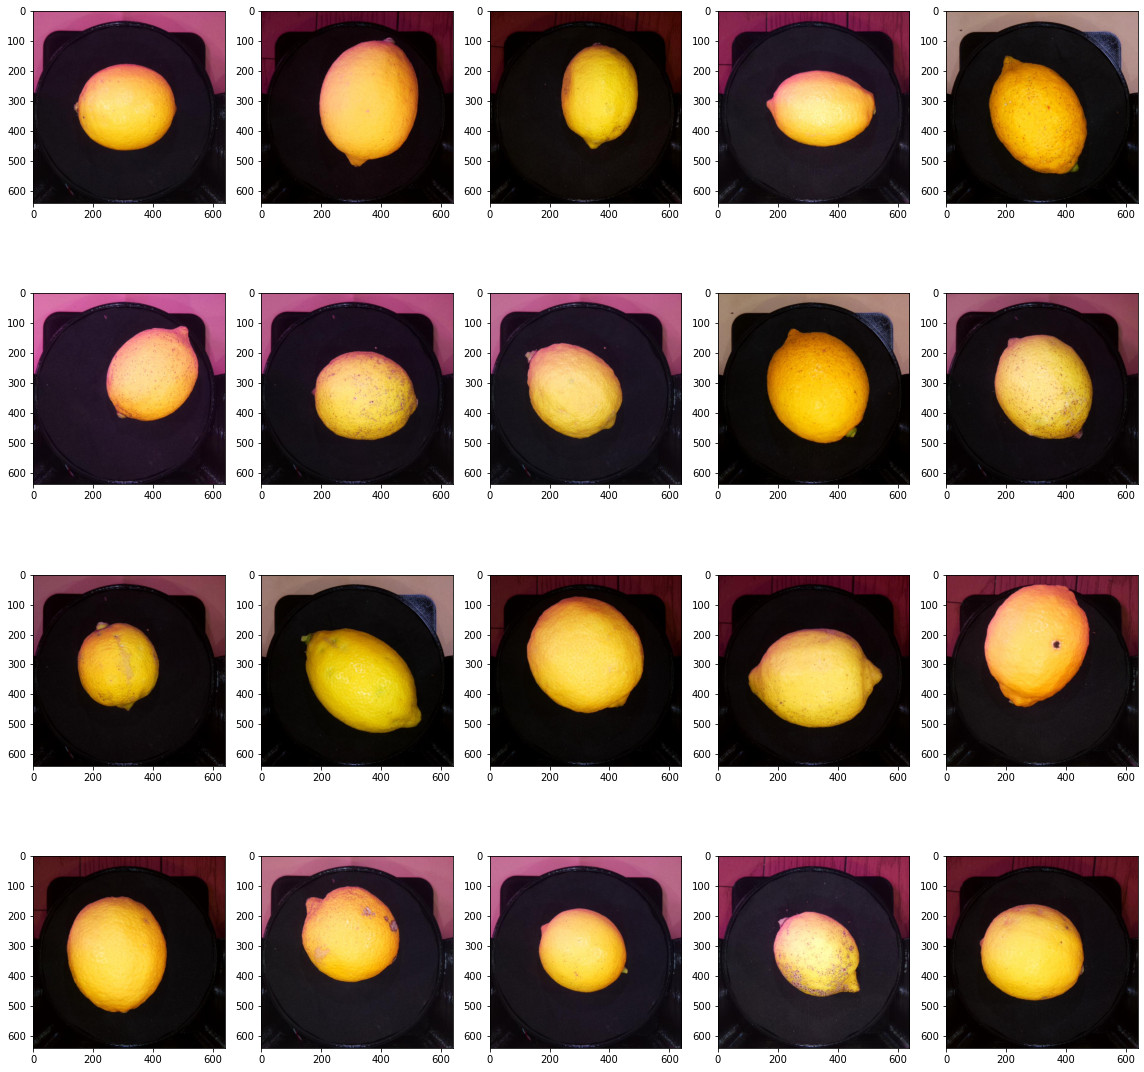

In [18]:
import matplotlib.pyplot as plt
from random import randint

classes = set()
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(16, 16))
axs = axs.flatten()
for i in range(20):
  #axs[i].imshow(dataset[randint(0,len(dataset)-1)])
  axs[i].imshow(dataset[i])
plt.tight_layout()

In [7]:
from classy_vision.models import build_model
from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp
from collections import defaultdict
import torch

use_cuda = torch.cuda.is_available()
DEVICE = torch.device('cuda' if use_cuda else 'cpu')

classification_model = build_model({"name": "efficientnet",
                     "model_name":"B1",
                     "num_classes":4,
                     "bn_momentum":0.010,
                     "bn_epsilon":1e-3,
                     "width_divisor":8,
                     "min_width":None,
                     "drop_connect_rate":0.2,
                     "use_se":False})


model_type = 'UnetPlusPlus'
#model_type = 'Linknet'
#model_type = 'FPN'
#model_type = 'PSPNet'

extra = defaultdict(dict)
extra['UnetPlusPlus'] = dict(decoder_attention_type=None,
                             decoder_use_batchnorm=True,
                             decoder_channels=(128, 64, 32, 16),
                             encoder_depth=4)

segmentation_model = getattr(smp, model_type)(
    encoder_name="efficientnet-b1",
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid',
    **extra[model_type]
)

class Model(torch.nn.Module):
    def __init__(self, segmentation_model, classification_model):
        super(Model, self).__init__()
        self.segmentation_model = segmentation_model
        for param in self.segmentation_model.parameters():
            param.requires_grad = False
        self.segmentation_model.eval()
        self.classification_model = classification_model
        self.training = True

    def forward(self, x):
        mask = self.segmentation_model(x)
        return self.classification_model(mask*x)

    def train(self, mode=True):
        r"""Sets the module in training mode."""      
        self.training = mode
        for module in self.classification_model.children():
            module.train(mode)
        return self

    def eval(self):
        r"""Sets the module in evaluation mode."""
        return self.classification_model.train(False)

model = Model(segmentation_model,classification_model)

filename = 'lemon_efficientnet_b1_20210320073019_400_type1.pt'
copyfile(f'drive/MyDrive/Colab Notebooks/SIGNATEHiroshimaLemon/models/{filename}',filename)
model.load_state_dict(torch.load(filename))

model.to(DEVICE)

Model(
  (segmentation_model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 

In [15]:
model.eval()

from torch import no_grad

rows = [['dummy0',0],['dummy1',1]]

with no_grad():
    for i in range(len(dataset)):
      test = image_transform(dataset[i])
      predict = model(test[None, :, :, :].cuda())
      predict_softmax = torch.log_softmax(predict, dim = 1)
      _, predict_class = torch.max(predict_softmax, dim = 1)
      rows.append([f'test_2_{i:04}.jpg',predict_class.item()])

In [16]:
import pandas as pd

pd.DataFrame(rows).to_csv('lemon_efficientnet_b1_20210320073019_400_test_2.csv',header=False,index=False)

In [19]:
rows

[['dummy0', 0],
 ['dummy1', 1],
 ['test_2_0000.jpg', 3],
 ['test_2_0001.jpg', 0],
 ['test_2_0002.jpg', 3],
 ['test_2_0003.jpg', 3],
 ['test_2_0004.jpg', 2],
 ['test_2_0005.jpg', 3],
 ['test_2_0006.jpg', 3],
 ['test_2_0007.jpg', 3],
 ['test_2_0008.jpg', 1],
 ['test_2_0009.jpg', 3],
 ['test_2_0010.jpg', 3],
 ['test_2_0011.jpg', 1],
 ['test_2_0012.jpg', 0],
 ['test_2_0013.jpg', 3],
 ['test_2_0014.jpg', 0],
 ['test_2_0015.jpg', 0],
 ['test_2_0016.jpg', 3],
 ['test_2_0017.jpg', 3],
 ['test_2_0018.jpg', 3],
 ['test_2_0019.jpg', 3],
 ['test_2_0020.jpg', 1],
 ['test_2_0021.jpg', 3],
 ['test_2_0022.jpg', 3],
 ['test_2_0023.jpg', 3],
 ['test_2_0024.jpg', 3],
 ['test_2_0025.jpg', 3],
 ['test_2_0026.jpg', 2],
 ['test_2_0027.jpg', 1],
 ['test_2_0028.jpg', 3],
 ['test_2_0029.jpg', 0],
 ['test_2_0030.jpg', 3],
 ['test_2_0031.jpg', 3],
 ['test_2_0032.jpg', 3],
 ['test_2_0033.jpg', 3],
 ['test_2_0034.jpg', 3],
 ['test_2_0035.jpg', 3],
 ['test_2_0036.jpg', 3],
 ['test_2_0037.jpg', 3],
 ['test_2_0038.jpg

In [17]:
copyfile('lemon_efficientnet_b1_20210320073019_400_test_2.csv','drive/MyDrive/Colab Notebooks/SIGNATEHiroshimaLemon/data/lemon_efficientnet_b1_20210320073019_400_test_2.csv')

'drive/MyDrive/Colab Notebooks/SIGNATEHiroshimaLemon/data/lemon_efficientnet_b1_20210320073019_400_test_2.csv'